In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

# Initial overview
print(df.shape)
print(df.info())
print(df.describe())

# Checking for missing values
print(df.isnull().sum())


(9134, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 n

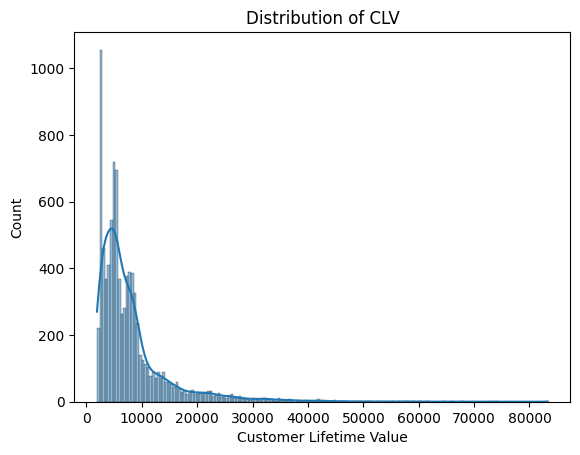

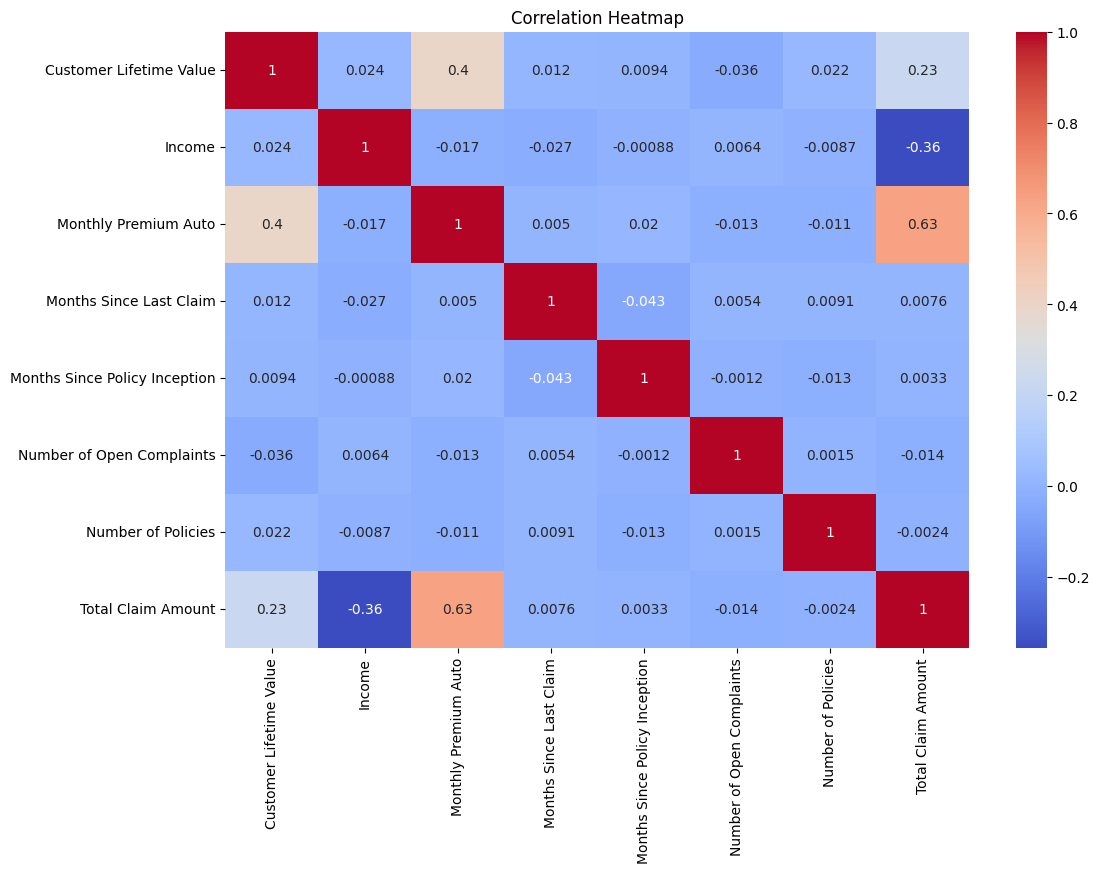

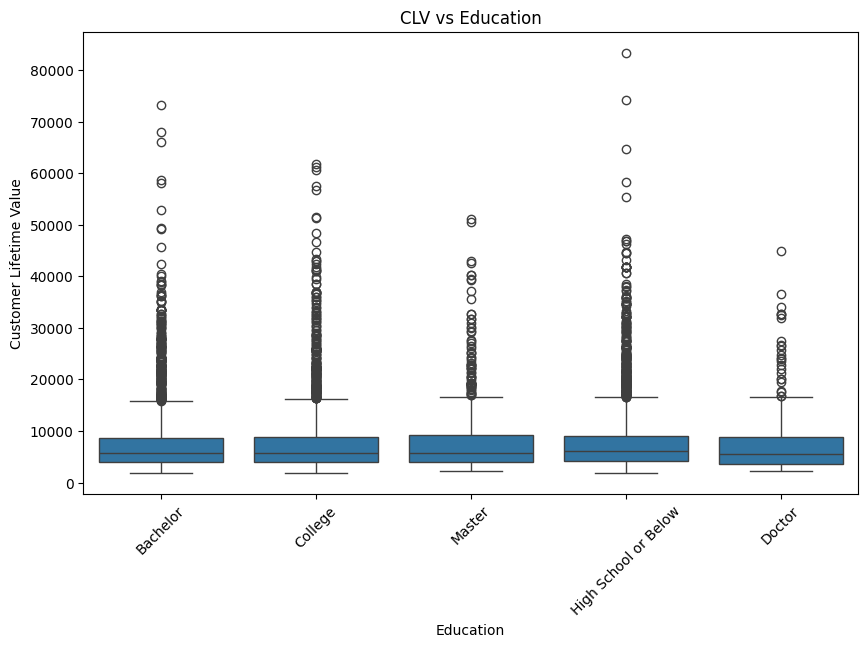

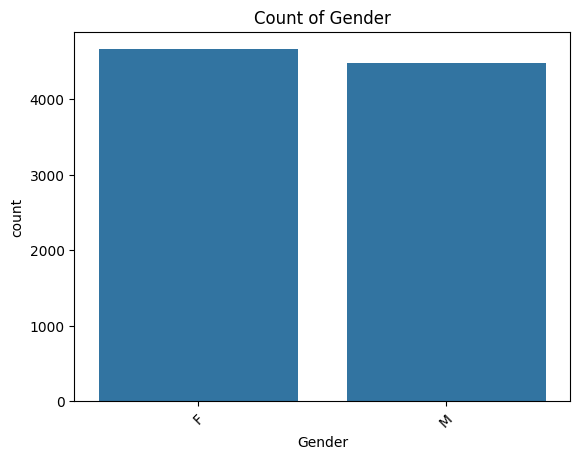

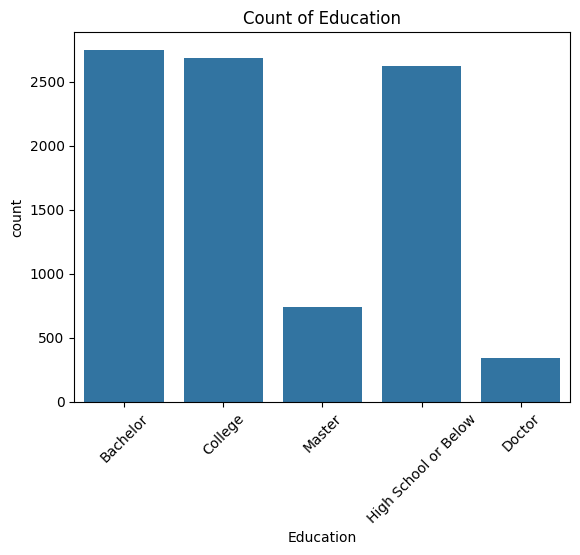

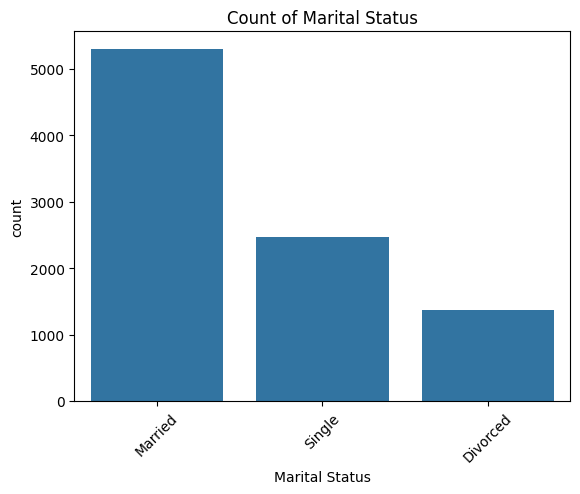

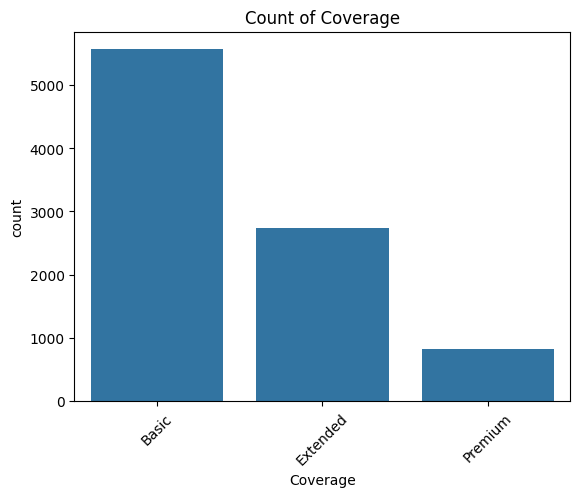

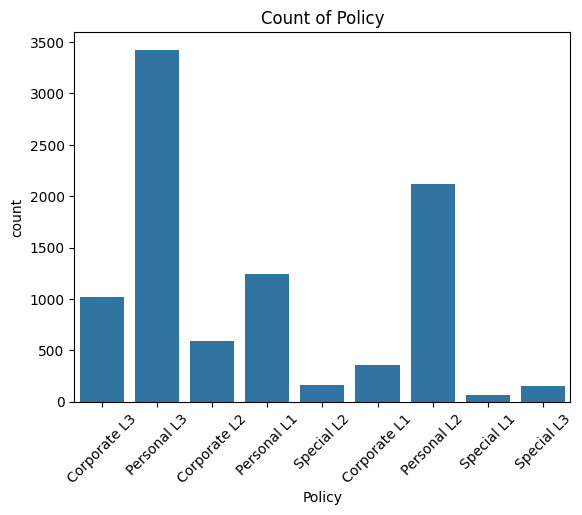

In [2]:
# Distribution of Target
sns.histplot(df['Customer Lifetime Value'], kde=True)
plt.title("Distribution of CLV")
plt.show()

# Correlation heatmap (for numerical features)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Boxplot for CLV vs Education
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='Customer Lifetime Value', data=df)
plt.title("CLV vs Education")
plt.xticks(rotation=45)
plt.show()

# Countplot for categorical features
cat_features = ['Gender', 'Education', 'Marital Status', 'Coverage', 'Policy']
for col in cat_features:
    sns.countplot(x=col, data=df)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()


Fitting 3 folds for each of 43 candidates, totalling 129 fits
Best Parameters: {'max_depth': 17, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 963}
MSE: 15631882.381168712
R² Score: 0.6966811887487567


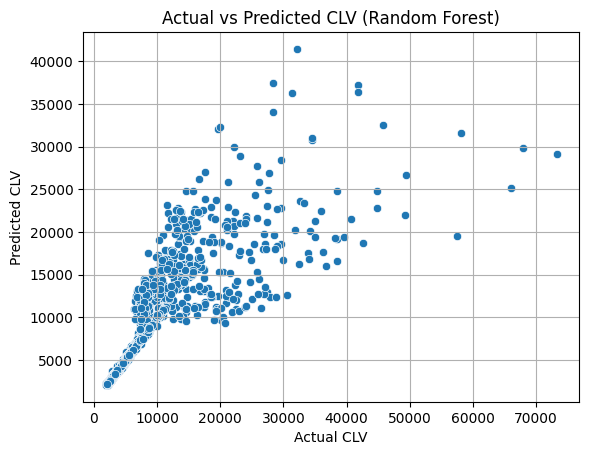

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint

# Here I have defined the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Defining the hyperparameter space to search
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]  # removed 'auto' as it's deprecated
}

# Here I am using RandomizedSearchCV to find the best combination of parameters
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=43,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fitting the model with training data and starting the tuning process
random_search.fit(X_train, y_train)

# Best parameters after tuning
print("Best Parameters:", random_search.best_params_)

# Making predictions using the best model found from tuning
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Here I have done model evaluation with the help of MSE and R² metrics
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Plotting actual vs predicted values to visually inspect performance
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted CLV (Random Forest)")
plt.grid(True)
plt.show()


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Drop identifier column
df = df.drop(columns=['Customer', 'Effective To Date'])

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Features and target
X = df.drop('Customer Lifetime Value', axis=1)
y = df['Customer Lifetime Value']

# Optional: log transform target if skewed
# y = np.log1p(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
